In [1]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run and export ISSM relaxation
# Mikayla Pascual 07/13/22
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import numpy as np
import pickle



could not import shapefile, PyShp has not been installed, no shapefile reading capabilities enabled


In [2]:
region = 'SAtoES'
start_year = 1985.

Opening ./Models/SAtoES_inversion.nc for reading 
solidearthsettings.solidearthsettings
lovenumbers.lovenumbers
rotational.rotational
results.solutionstep
empty init


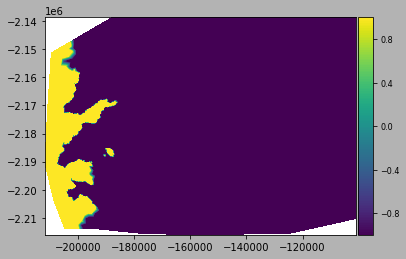

In [3]:
md = loadmodel('./Models/SAtoES_inversion.nc')
plotmodel(md, 'data', md.mask.ice_levelset)

In [4]:
## Relaxation
#Put results of inversion back into the model for forward runs
md.friction.coefficient=md.results.StressbalanceSolution.FrictionCoefficient
relaxation_years = 1 #try 5 years if 1 runs quickly

# Special post-processing of inverted friction coefficient
filename = 'Exp/' +region+ '_coeffront_after_inversion.exp'
if os.path.isfile(filename):
  pos = find(ContourToNodes(md.mesh.x, md.mesh.y, filename, 1))
  md.friction.coefficient[pos] = 10

md.initialization.pressure = np.zeros([md.mesh.numberofvertices,1])
md.initialization.temperature = 250*np.ones([md.mesh.numberofvertices,1])

# Set parameters
md.inversion.iscontrol=0;
md.timestepping.start_time = start_year;
md.timestepping.time_step  = .02;
md.timestepping.final_time = start_year + relaxation_years;
md.settings.output_frequency = (1/md.timestepping.time_step)/5; # 5/yr

In [25]:
from frontalforcingsrignot import frontalforcingsrignot
frontalforcingsrignot()

   Frontalforcings parameters:
         basin                  : N/A             -- basin ID for vertices
         numberofbasins         : 0.0             -- number of basins
         subglacial_discharge   : N/A             -- sum of subglacial discharge for each basin [m / d]
         thermalforcing         : N/A             -- thermal forcing [C]

In [29]:
# We set the transient parameters
md.transient.ismovingfront=1
md.transient.isthermal=0
md.transient.isstressbalance=1
md.transient.ismasstransport=1
md.transient.isgroundingline=1
md.groundingline.migration = 'SubelementMigration'

# We set the ocean conditions
from frontalforcingsrignot import frontalforcingsrignot
md.frontalforcings = frontalforcingsrignot()
md.frontalforcings.subglacial_discharge = 2.6
md.frontalforcings.thermalforcing = 15.7

# We set the calving model (no moving front ... spclevelset is actually ignored)
from calvingvonmises import calvingvonmises
md.calving = calvingvonmises()
md.calving.stress_threshold_groundedice = md.calving.stress_threshold_groundedice * 0.1
md.levelset.spclevelset = np.nan * np.ones([md.mesh.numberofvertices,1])
#md.calving.calvingrate = np.zeros([md.mesh.numberofvertices,1])
#md.frontalforcings.meltingrate = np.zeros([md.mesh.numberofvertices,1])
#md.calving.meltingrate = np.ones([md.mesh.numberofvertices,1])

# Set bed = base for grounded ice
#md.geometry.base = md.geometry.bed
#md.geometry.thickness = md.geometry.surface - md.geometry.base

# Set the requested outputs
md.stressbalance.requested_outputs=['default']
md.transient.requested_outputs=['default','IceVolumeAboveFloatation']

# Go solve
md.verbose.solution=1
md.cluster = generic()
md.settings.waitonlock = np.inf
md = solve(md,'transient')

checking model consistency


ValueError: zero-size array to reduction operation fmin which has no identity

In [6]:
from export_netCDF import export_netCDF

md.inversion.cost_functions = md.inversion.cost_functions.astype(np.float64)
for i in range(len(md.results.TransientSolution)):
    md.results.TransientSolution[i].step = np.float64(md.results.TransientSolution[i].step)
    
export_netCDF(md, "./Models/SAtoES_relaxation.nc")

File ./Models/SAtoES_relaxation.nc allready exist


Give a new name or "delete" to replace:  delete


field md.solidearth.external is None
qmu is skipped until it is more stable


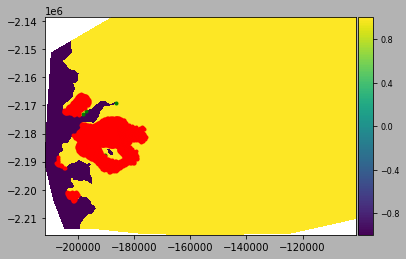

In [7]:
time = [md.results.TransientSolution[i].time for i in range(len(md.results.TransientSolution))]
VAF = [md.results.TransientSolution[i].IceVolumeAboveFloatation for i in range(len(md.results.TransientSolution))]

# Look for terminus advance
idx = np.logical_and(np.array(md.mask.ice_levelset) > 0, \
                     np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel() <= 0)
pos_advance = np.where(idx)[0]

# Look for terminus retreat
idx = np.logical_and(np.array(md.mask.ice_levelset) < 0, \
                     np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel() >= 0)
pos_retreat = np.where(idx)[0]

#fig = plt.figure(figsize=(10,10))
#plotmodel(md, 'data', np.array(md.mask.ice_levelset), \
#              'data', np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel(), \
#              'caxis#all', [-1., +1.])
plotmodel(md, 'data', np.array(md.mask.ice_levelset) - np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel(), \
              'caxis#all', [-1, +1])

plt.plot(md.mesh.x[pos_advance], md.mesh.y[pos_advance], 'g.')
plt.plot(md.mesh.x[pos_retreat], md.mesh.y[pos_retreat], 'r.')

In [10]:
md.results.TransientSolution[5].MaskIceLevelset

array([[-16710.24741481],
       [  5284.22963663],
       [  4062.45684144],
       ...,
       [  -812.40708016],
       [ -1777.59417679],
       [-89056.42866602]])

In [25]:
md.calving

   Calving VonMises parameters:
         stress_threshold_gro...: 500000.0        -- sigma_max applied to grounded ice only [Pa]
         stress_threshold_flo...: 150000.0        -- sigma_max applied to floating ice only [Pa]
         min_thickness          : 0.0             -- minimum thickness below which no ice is allowed [m]